## Importing the required libraries

In [4]:
import librosa #Audio
import librosa.display
import numpy as np #Mathametical
import matplotlib.pyplot as plt
import tensorflow as tf #Layers
from matplotlib.pyplot import specgram
import keras #Nural Networking
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix #Machine Learning
from sklearn.preprocessing import LabelEncoder
from scipy.fftpack import fft
from scipy import signal #Statistical
from scipy.io import wavfile
from tqdm import tqdm
import seaborn as sns #Plot

In [9]:
from keras import regularizers

In [10]:
import os #Path

In [17]:
mylist= os.listdir('RawData/')

In [18]:
type(mylist)

list

In [19]:
print(mylist[0])

03-01-01-01-01-01-01.wav


In [20]:
print(len(mylist[0]))

24


In [21]:
print("Modality (01 = full-AV, 02 = video-only, 03 = audio-only): "+mylist[0][0:2])
print("Vocal channel (01 = speech, 02 = song): "+mylist[0][3:5])
print("Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised): "+mylist[0][6:8])
print("Statement (01 = \"Kids are talking by the door\", 02 = \"Dogs are sitting by the door\"): "+mylist[0][9:11])
print("Repetition (01 = 1st repetition, 02 = 2nd repetition): "+mylist[0][12:14])
print("Actor (01 to 24. Odd numbered actors are male, even numbered actors are female): "+mylist[0][15:17])


Modality (01 = full-AV, 02 = video-only, 03 = audio-only): 03
Vocal channel (01 = speech, 02 = song): 01
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised): 01
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"): 01
Repetition (01 = 1st repetition, 02 = 2nd repetition): 01
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female): 01


## Plotting the audio file's waveform and its spectrogram

In [5]:
data, sampling_rate = librosa.load('RawData/03-01-01-01-01-01-17.wav')
print("Audio Time Series: \n",data)
print("Sampling Rate: ",sampling_rate) #Per Second Rate of Input.

Audio Time Series: 
 [ 2.1882441e-04  3.3067702e-04  3.1655972e-04 ... -7.9239806e-05
 -9.3955183e-05  0.0000000e+00]
Sampling Rate:  22050


Populating the interactive namespace from numpy and matplotlib


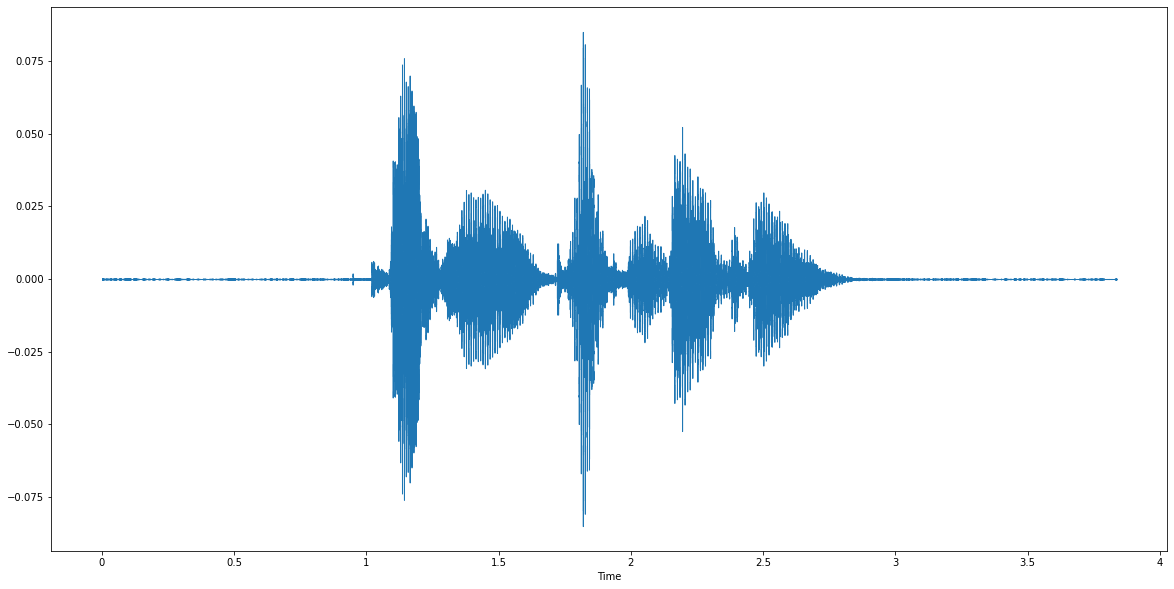

In [8]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 
'''Is Used Return All Paths That Match a Specific Pattern'''

plt.figure(figsize=(20, 10))
librosa.display.waveshow(data, sr=sampling_rate)

In [24]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-01-01-01-01-01-17.wav')
print("Sample Rate: ",sr)
print("Number of channel: ",x.shape[:1])
print("Length: ",(x.shape[0]/sr),"s")


Sample Rate:  48000
Number of channel:  (184184,)
Length:  3.8371666666666666 s


<ipython-input-24-1f22e15b9d93>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('RawData/03-01-01-01-01-01-17.wav')


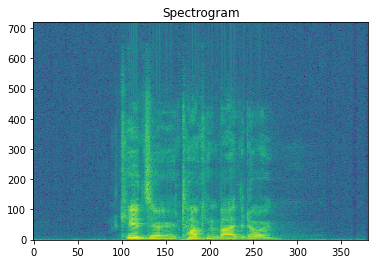

In [25]:
## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin) #Bit Correction.

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft) #Mel Frequency Cepstral Coefficient
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.title("Spectrogram")
plt.show()

The first step in any automatic speech recognition system is to extract features i.e. identify the components of the audio signal that are good for identifying the linguistic content and discarding all the other stuff which carries information like background noise, emotion etc.

## Setting the labels and Createing Datasets.

In [26]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')

In [27]:
feel_labels = pd.DataFrame({"label":feeling_list})

In [28]:
feel_labels.head()

,label
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm


In [29]:
feel_labels["label"].unique()

array(['male_calm', 'female_calm', 'male_happy', 'female_happy',
       'male_sad', 'female_sad', 'male_angry', 'female_angry',
       'male_fearful', 'female_fearful'], dtype=object)

## Getting the features of audio files using librosa

In [30]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [31]:
df.head()

,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-65.70765, -65.70765, -63.11472, -61.518997, ..."
2,"[-65.4825, -65.4825, -65.4825, -65.4825, -65.4..."
3,"[-64.52845, -64.52845, -64.52845, -64.52845, -..."
4,"[-63.645668, -59.99304, -61.869602, -67.49577,..."


In [32]:
df3 = pd.DataFrame(df['feature'].values.tolist())
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-58.802044,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.241898,-61.355312
1,-65.707649,-65.707649,-63.114719,-61.518997,-61.097141,-63.424599,-63.720066,-56.854614,-55.168972,-54.639999,...,-38.301201,-39.792141,-40.613159,-41.209202,-41.439201,-43.994286,-49.399620,-50.591599,-49.111824,-48.155380
2,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,...,-29.193260,-31.346556,-34.310772,-35.800705,-35.936115,-37.631844,-40.119411,-41.662888,-41.552467,-41.973667
3,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-65.928223,...,-48.872002,-48.674301,-48.596073,-47.602745,-43.049198,-42.659542,-43.188560,-44.001240,-43.328056,-42.984985
4,-63.645668,-59.993038,-61.869602,-67.495773,-71.071808,-65.679817,-63.394402,-65.503349,-61.856644,-60.005428,...,-33.817356,-39.071327,-41.897121,-40.865437,-38.290604,-36.372398,-37.915779,-40.026127,-43.313309,-44.846916


In [33]:
rnewdf = pd.concat([df3,feel_labels], axis=1)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,label
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.241898,-61.355312,male_calm
1,-65.707649,-65.707649,-63.114719,-61.518997,-61.097141,-63.424599,-63.720066,-56.854614,-55.168972,-54.639999,...,-39.792141,-40.613159,-41.209202,-41.439201,-43.994286,-49.399620,-50.591599,-49.111824,-48.155380,female_calm
2,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,...,-31.346556,-34.310772,-35.800705,-35.936115,-37.631844,-40.119411,-41.662888,-41.552467,-41.973667,male_calm
3,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-65.928223,...,-48.674301,-48.596073,-47.602745,-43.049198,-42.659542,-43.188560,-44.001240,-43.328056,-42.984985,female_calm
4,-63.645668,-59.993038,-61.869602,-67.495773,-71.071808,-65.679817,-63.394402,-65.503349,-61.856644,-60.005428,...,-39.071327,-41.897121,-40.865437,-38.290604,-36.372398,-37.915779,-40.026127,-43.313309,-44.846916,male_calm


In [34]:
from sklearn.utils import shuffle
rnewdf = shuffle(rnewdf)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,label
1754,-61.703941,-63.717766,-63.808411,-63.452225,-60.869267,-61.164833,-64.929016,-64.929016,-62.103813,-62.533733,...,-33.941124,-33.571327,-34.499413,-37.572739,-38.104038,-35.707527,-34.578022,-27.964832,-21.463055,male_fearful
923,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.291565,-45.478447,...,-43.569321,-43.577682,-43.927559,-43.415108,-43.463509,-44.540195,-45.193157,-45.837307,-45.681561,female_fearful
1072,-59.440392,-59.440392,-59.355549,-56.543247,-56.170891,-58.080856,-53.341179,-50.009972,-49.440495,-45.397640,...,-43.260983,-41.795120,-41.193386,-43.303402,-42.872871,-42.317581,-44.918644,-28.839031,-21.543606,female_calm
1667,-49.509216,-50.563469,-49.887871,-48.968792,-50.830566,-50.118370,-50.165569,-51.492119,-51.544106,-51.544106,...,-16.246412,-16.420534,-17.731512,-17.738985,-19.116766,-18.761425,-19.794525,-17.455797,-14.312067,male_angry
1875,-43.528397,-42.754307,-43.600807,-44.283516,-43.679958,-43.054157,-43.744614,-43.911400,-45.600124,-42.827415,...,-36.605808,-35.384476,-36.067268,-35.236687,-36.835464,-30.092945,-30.374094,-28.824589,-21.535383,female_fearful


In [35]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [36]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [37]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,label
1754,-61.703941,-63.717766,-63.808411,-63.452225,-60.869267,-61.164833,-64.929016,-64.929016,-62.103813,-62.533733,...,-33.941124,-33.571327,-34.499413,-37.572739,-38.104038,-35.707527,-34.578022,-27.964832,-21.463055,male_fearful
923,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.291565,-45.478447,...,-43.569321,-43.577682,-43.927559,-43.415108,-43.463509,-44.540195,-45.193157,-45.837307,-45.681561,female_fearful
1667,-49.509216,-50.563469,-49.887871,-48.968792,-50.830566,-50.118370,-50.165569,-51.492119,-51.544106,-51.544106,...,-16.246412,-16.420534,-17.731512,-17.738985,-19.116766,-18.761425,-19.794525,-17.455797,-14.312067,male_angry
1875,-43.528397,-42.754307,-43.600807,-44.283516,-43.679958,-43.054157,-43.744614,-43.911400,-45.600124,-42.827415,...,-36.605808,-35.384476,-36.067268,-35.236687,-36.835464,-30.092945,-30.374094,-28.824589,-21.535383,female_fearful
15,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,...,-52.096539,-54.628349,-61.964287,-61.394615,-57.863480,-54.479099,-57.676800,-60.140770,-63.900982,female_calm


In [38]:
trainfeatures = train.iloc[:, :-1]
trainfeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1754,-61.703941,-63.717766,-63.808411,-63.452225,-60.869267,-61.164833,-64.929016,-64.929016,-62.103813,-62.533733,...,-33.820915,-33.941124,-33.571327,-34.499413,-37.572739,-38.104038,-35.707527,-34.578022,-27.964832,-21.463055
923,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.478447,-45.291565,-45.478447,...,-42.287746,-43.569321,-43.577682,-43.927559,-43.415108,-43.463509,-44.540195,-45.193157,-45.837307,-45.681561
1667,-49.509216,-50.563469,-49.887871,-48.968792,-50.830566,-50.118370,-50.165569,-51.492119,-51.544106,-51.544106,...,-16.182947,-16.246412,-16.420534,-17.731512,-17.738985,-19.116766,-18.761425,-19.794525,-17.455797,-14.312067
1875,-43.528397,-42.754307,-43.600807,-44.283516,-43.679958,-43.054157,-43.744614,-43.911400,-45.600124,-42.827415,...,-36.239365,-36.605808,-35.384476,-36.067268,-35.236687,-36.835464,-30.092945,-30.374094,-28.824589,-21.535383
15,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,-68.325424,...,-55.190514,-52.096539,-54.628349,-61.964287,-61.394615,-57.863480,-54.479099,-57.676800,-60.140770,-63.900982


In [39]:
trainlabel = train.iloc[:, -1:]
trainlabel.head()

,label
1754,male_fearful
923,female_fearful
1667,male_angry
1875,female_fearful
15,female_calm


In [40]:
testfeatures = test.iloc[:, :-1]
testfeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1072,-59.440392,-59.440392,-59.355549,-56.543247,-56.170891,-58.080856,-53.341179,-50.009972,-49.440495,-45.397640,...,-43.078350,-43.260983,-41.795120,-41.193386,-43.303402,-42.872871,-42.317581,-44.918644,-28.839031,-21.543606
217,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.049198,...,-52.061703,-53.759277,-53.623848,-55.661297,-53.975624,-54.425545,-56.314812,-56.524208,-54.685539,-55.919754
1509,-46.285847,-46.712002,-47.901199,-47.184330,-46.584187,-46.630337,-48.000950,-49.209927,-49.081730,-48.848267,...,-36.811634,-37.458694,-36.762352,-35.557991,-35.194633,-34.766972,-34.958096,-35.875130,-24.570772,-15.922441
932,-50.677391,-50.643154,-50.498825,-50.677391,-50.677391,-50.677391,-50.677391,-50.677391,-50.677391,-50.677391,...,-36.571445,-37.373428,-37.479317,-39.878986,-39.241016,-40.303493,-41.163029,-39.278946,-41.395569,-43.120296
1819,-51.955669,-51.081440,-51.229378,-51.757290,-52.012375,-51.750237,-50.193256,-46.999580,-45.872704,-45.046593,...,-26.419416,-27.426849,-28.060581,-29.361835,-26.532412,-24.975149,-21.543062,-19.522160,-20.393415,-24.180050


In [41]:
testlabel = test.iloc[:, -1:]
testlabel.head()

,label
1072,female_calm
217,female_happy
1509,female_sad
932,male_fearful
1819,male_fearful


In [43]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)
                                                                                                                                
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train.ravel()))
y_test = np_utils.to_categorical(lb.fit_transform(y_test.ravel()))


In [44]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [45]:
X_train.shape

(1522, 216)

## Changing dimension for CNN model

In [46]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [48]:
x_traincnn

array([[[-61.70394135],
        [-63.71776581],
        [-63.80841064],
        ...,
        [-34.578022  ],
        [-27.96483231],
        [-21.46305466]],

       [[-45.47844696],
        [-45.47844696],
        [-45.47844696],
        ...,
        [-45.1931572 ],
        [-45.83730698],
        [-45.68156052]],

       [[-49.50921631],
        [-50.56346893],
        [-49.88787079],
        ...,
        [-19.79452515],
        [-17.4557972 ],
        [-14.31206703]],

       ...,

       [[-43.21216583],
        [-42.33470917],
        [-44.16660309],
        ...,
        [-21.15762138],
        [-13.50240898],
        [ -8.13083458]],

       [[-58.40241241],
        [-58.78308868],
        [-60.86989975],
        ...,
        [-56.73955536],
        [-56.37461853],
        [-58.7474556 ]],

       [[-50.06677628],
        [-47.90478516],
        [-48.66000748],
        ...,
        [-40.26498032],
        [-24.39129448],
        [-16.44720459]]])

In [50]:
x_testcnn

array([[[-59.44039154],
        [-59.44039154],
        [-59.35554886],
        ...,
        [-44.91864395],
        [-28.83903122],
        [-21.5436058 ]],

       [[-61.04076767],
        [-61.04076767],
        [-61.04076767],
        ...,
        [-56.52420807],
        [-54.68553925],
        [-55.91975403]],

       [[-46.28584671],
        [-46.7120018 ],
        [-47.90119934],
        ...,
        [-35.8751297 ],
        [-24.57077217],
        [-15.92244148]],

       ...,

       [[-48.5235672 ],
        [-48.44527817],
        [-49.61540985],
        ...,
        [-25.73049545],
        [-22.50478172],
        [-18.88602066]],

       [[-35.66483307],
        [-38.87537003],
        [-41.55642319],
        ...,
        [-28.69045258],
        [-27.11485863],
        [-25.82102585]],

       [[-56.66661835],
        [-56.73847198],
        [-55.75902939],
        ...,
        [-51.55858994],
        [-51.412117  ],
        [-51.99536514]]])

# CNN model is Developed with Keras and constructed with 7 layers — 6 Conv1D layers followed by a Dense layer.

In [51]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',input_shape=(216,1)))#1
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))#2
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))#3
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))#4
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))#5
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))#6
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))#7
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout (Dropout)           (None, 216, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                        

F-Score, Recall, Precesion.

In [59]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fscore(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Compile Model

In [61]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy', fscore, precision, recall ])

### Removed the whole training part for avoiding unnecessary long epochs list

Fit Model

In [62]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
96/96 [==============================] - 6s 43ms/step - loss: 2.3389 - accuracy: 0.1229 - fscore: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2536 - val_accuracy: 0.1732 - val_fscore: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/700
96/96 [==============================] - 4s 40ms/step - loss: 2.2202 - accuracy: 0.1656 - fscore: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2073 - val_accuracy: 0.1899 - val_fscore: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/700
96/96 [==============================] - 4s 40ms/step - loss: 2.1655 - accuracy: 0.1774 - fscore: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1567 - val_accuracy: 0.2179 - val_fscore: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/700
96/96 [==============================] - 4s 41ms/step - loss: 2.1151 - accuracy: 0.2076 - fscore: 0.0000e+00 - precision: 0.0000e+

96/96 [==============================] - 7s 68ms/step - loss: 1.5762 - accuracy: 0.3876 - fscore: 0.0827 - precision: 0.4714 - recall: 0.0462 - val_loss: 1.6580 - val_accuracy: 0.3631 - val_fscore: 0.0656 - val_precision: 0.5000 - val_recall: 0.0353
Epoch 32/700
96/96 [==============================] - 7s 68ms/step - loss: 1.5674 - accuracy: 0.4008 - fscore: 0.0884 - precision: 0.4780 - recall: 0.0501 - val_loss: 1.6587 - val_accuracy: 0.3575 - val_fscore: 0.0358 - val_precision: 0.3043 - val_recall: 0.0190
Epoch 33/700
96/96 [==============================] - 7s 69ms/step - loss: 1.5514 - accuracy: 0.3890 - fscore: 0.1025 - precision: 0.5278 - recall: 0.0579 - val_loss: 1.6228 - val_accuracy: 0.3855 - val_fscore: 0.0777 - val_precision: 0.4348 - val_recall: 0.0435
Epoch 34/700
96/96 [==============================] - 7s 68ms/step - loss: 1.5382 - accuracy: 0.4192 - fscore: 0.1070 - precision: 0.5510 - recall: 0.0605 - val_loss: 1.6397 - val_accuracy: 0.3827 - val_fscore: 0.0786 - val_

96/96 [==============================] - 7s 72ms/step - loss: 1.2735 - accuracy: 0.5020 - fscore: 0.3429 - precision: 0.6677 - recall: 0.2389 - val_loss: 1.4986 - val_accuracy: 0.4162 - val_fscore: 0.2986 - val_precision: 0.5528 - val_recall: 0.2111
Epoch 94/700
96/96 [==============================] - 7s 72ms/step - loss: 1.2767 - accuracy: 0.5039 - fscore: 0.3277 - precision: 0.6873 - recall: 0.2227 - val_loss: 1.5868 - val_accuracy: 0.3939 - val_fscore: 0.2680 - val_precision: 0.5321 - val_recall: 0.1848
Epoch 95/700
96/96 [==============================] - 7s 75ms/step - loss: 1.2650 - accuracy: 0.5204 - fscore: 0.3456 - precision: 0.6731 - recall: 0.2396 - val_loss: 1.4208 - val_accuracy: 0.4525 - val_fscore: 0.3187 - val_precision: 0.6850 - val_recall: 0.2174
Epoch 96/700
96/96 [==============================] - 7s 73ms/step - loss: 1.2650 - accuracy: 0.5020 - fscore: 0.3547 - precision: 0.6862 - recall: 0.2454 - val_loss: 1.4488 - val_accuracy: 0.4106 - val_fscore: 0.2803 - val_

96/96 [==============================] - 7s 68ms/step - loss: 1.1272 - accuracy: 0.5769 - fscore: 0.4472 - precision: 0.7213 - recall: 0.3307 - val_loss: 1.4254 - val_accuracy: 0.4330 - val_fscore: 0.3223 - val_precision: 0.5929 - val_recall: 0.2283
Epoch 156/700
96/96 [==============================] - 7s 71ms/step - loss: 1.1329 - accuracy: 0.5604 - fscore: 0.4556 - precision: 0.7243 - recall: 0.3392 - val_loss: 1.4290 - val_accuracy: 0.4441 - val_fscore: 0.3318 - val_precision: 0.5611 - val_recall: 0.2418
Epoch 157/700
96/96 [==============================] - 7s 69ms/step - loss: 1.1277 - accuracy: 0.5710 - fscore: 0.4406 - precision: 0.7081 - recall: 0.3314 - val_loss: 1.4309 - val_accuracy: 0.4441 - val_fscore: 0.3438 - val_precision: 0.5989 - val_recall: 0.2500
Epoch 158/700
96/96 [==============================] - 7s 70ms/step - loss: 1.1360 - accuracy: 0.5650 - fscore: 0.4463 - precision: 0.7166 - recall: 0.3314 - val_loss: 1.4226 - val_accuracy: 0.4469 - val_fscore: 0.3491 - v

96/96 [==============================] - 7s 69ms/step - loss: 1.0109 - accuracy: 0.6170 - fscore: 0.5239 - precision: 0.7470 - recall: 0.4121 - val_loss: 1.3788 - val_accuracy: 0.4777 - val_fscore: 0.3736 - val_precision: 0.6103 - val_recall: 0.2772
Epoch 218/700
96/96 [==============================] - 7s 68ms/step - loss: 1.0010 - accuracy: 0.6268 - fscore: 0.5353 - precision: 0.7625 - recall: 0.4206 - val_loss: 1.4269 - val_accuracy: 0.4749 - val_fscore: 0.3884 - val_precision: 0.6148 - val_recall: 0.2935
Epoch 219/700
96/96 [==============================] - 7s 69ms/step - loss: 1.0024 - accuracy: 0.6242 - fscore: 0.5391 - precision: 0.7565 - recall: 0.4258 - val_loss: 1.4973 - val_accuracy: 0.4358 - val_fscore: 0.3464 - val_precision: 0.5450 - val_recall: 0.2609
Epoch 220/700
96/96 [==============================] - 7s 69ms/step - loss: 1.0047 - accuracy: 0.6078 - fscore: 0.5299 - precision: 0.7601 - recall: 0.4141 - val_loss: 1.4029 - val_accuracy: 0.4665 - val_fscore: 0.3725 - v

96/96 [==============================] - 8s 79ms/step - loss: 0.8842 - accuracy: 0.6689 - fscore: 0.6146 - precision: 0.8004 - recall: 0.5078 - val_loss: 1.4108 - val_accuracy: 0.4888 - val_fscore: 0.4158 - val_precision: 0.5712 - val_recall: 0.3315
Epoch 280/700
96/96 [==============================] - 7s 78ms/step - loss: 0.8842 - accuracy: 0.6643 - fscore: 0.5960 - precision: 0.7619 - recall: 0.4974 - val_loss: 1.4446 - val_accuracy: 0.4777 - val_fscore: 0.4055 - val_precision: 0.5595 - val_recall: 0.3261
Epoch 281/700
96/96 [==============================] - 7s 76ms/step - loss: 0.8742 - accuracy: 0.6866 - fscore: 0.6115 - precision: 0.7976 - recall: 0.5013 - val_loss: 1.4843 - val_accuracy: 0.4525 - val_fscore: 0.3992 - val_precision: 0.5527 - val_recall: 0.3170
Epoch 282/700
96/96 [==============================] - 7s 76ms/step - loss: 0.8771 - accuracy: 0.6735 - fscore: 0.6110 - precision: 0.7831 - recall: 0.5091 - val_loss: 1.5175 - val_accuracy: 0.4330 - val_fscore: 0.3925 - v

96/96 [==============================] - 7s 77ms/step - loss: 0.7614 - accuracy: 0.7286 - fscore: 0.6879 - precision: 0.8277 - recall: 0.5957 - val_loss: 1.4777 - val_accuracy: 0.5223 - val_fscore: 0.4351 - val_precision: 0.5624 - val_recall: 0.3605
Epoch 342/700
96/96 [==============================] - 8s 78ms/step - loss: 0.7591 - accuracy: 0.7254 - fscore: 0.6964 - precision: 0.8369 - recall: 0.6029 - val_loss: 1.4982 - val_accuracy: 0.4525 - val_fscore: 0.4253 - val_precision: 0.5432 - val_recall: 0.3560
Epoch 343/700
96/96 [==============================] - 8s 79ms/step - loss: 0.7566 - accuracy: 0.7313 - fscore: 0.6908 - precision: 0.8331 - recall: 0.5957 - val_loss: 1.4488 - val_accuracy: 0.4832 - val_fscore: 0.4246 - val_precision: 0.5424 - val_recall: 0.3560
Epoch 344/700
96/96 [==============================] - 8s 80ms/step - loss: 0.7548 - accuracy: 0.7424 - fscore: 0.6918 - precision: 0.8329 - recall: 0.5983 - val_loss: 1.4956 - val_accuracy: 0.4860 - val_fscore: 0.4324 - v

96/96 [==============================] - 8s 79ms/step - loss: 0.6342 - accuracy: 0.7852 - fscore: 0.7560 - precision: 0.8638 - recall: 0.6784 - val_loss: 1.5415 - val_accuracy: 0.5000 - val_fscore: 0.4666 - val_precision: 0.5606 - val_recall: 0.4040
Epoch 404/700
96/96 [==============================] - 8s 82ms/step - loss: 0.6379 - accuracy: 0.7911 - fscore: 0.7654 - precision: 0.8655 - recall: 0.6908 - val_loss: 1.5569 - val_accuracy: 0.5056 - val_fscore: 0.4553 - val_precision: 0.5456 - val_recall: 0.3958
Epoch 405/700
96/96 [==============================] - 8s 80ms/step - loss: 0.6415 - accuracy: 0.7878 - fscore: 0.7502 - precision: 0.8534 - recall: 0.6758 - val_loss: 1.5480 - val_accuracy: 0.4860 - val_fscore: 0.4485 - val_precision: 0.5293 - val_recall: 0.3931
Epoch 406/700
96/96 [==============================] - 8s 79ms/step - loss: 0.6379 - accuracy: 0.7871 - fscore: 0.7486 - precision: 0.8593 - recall: 0.6686 - val_loss: 1.5594 - val_accuracy: 0.4916 - val_fscore: 0.4487 - v

96/96 [==============================] - 8s 82ms/step - loss: 0.5262 - accuracy: 0.8338 - fscore: 0.8134 - precision: 0.8981 - recall: 0.7480 - val_loss: 1.6119 - val_accuracy: 0.5056 - val_fscore: 0.4890 - val_precision: 0.5677 - val_recall: 0.4339
Epoch 466/700
96/96 [==============================] - 8s 83ms/step - loss: 0.5287 - accuracy: 0.8384 - fscore: 0.8154 - precision: 0.8939 - recall: 0.7552 - val_loss: 1.6224 - val_accuracy: 0.5028 - val_fscore: 0.4717 - val_precision: 0.5422 - val_recall: 0.4230
Epoch 467/700
96/96 [==============================] - 8s 83ms/step - loss: 0.5182 - accuracy: 0.8423 - fscore: 0.8211 - precision: 0.8955 - recall: 0.7611 - val_loss: 1.7013 - val_accuracy: 0.4721 - val_fscore: 0.4458 - val_precision: 0.5008 - val_recall: 0.4040
Epoch 468/700
96/96 [==============================] - 8s 84ms/step - loss: 0.5250 - accuracy: 0.8371 - fscore: 0.8214 - precision: 0.8989 - recall: 0.7617 - val_loss: 1.6387 - val_accuracy: 0.4693 - val_fscore: 0.4636 - v

96/96 [==============================] - 7s 72ms/step - loss: 0.4247 - accuracy: 0.8739 - fscore: 0.8569 - precision: 0.9202 - recall: 0.8053 - val_loss: 1.7006 - val_accuracy: 0.4972 - val_fscore: 0.4903 - val_precision: 0.5426 - val_recall: 0.4493
Epoch 528/700
96/96 [==============================] - 7s 76ms/step - loss: 0.4127 - accuracy: 0.8850 - fscore: 0.8704 - precision: 0.9231 - recall: 0.8268 - val_loss: 1.8172 - val_accuracy: 0.4749 - val_fscore: 0.4607 - val_precision: 0.5143 - val_recall: 0.4203
Epoch 529/700
96/96 [==============================] - 7s 71ms/step - loss: 0.4186 - accuracy: 0.8804 - fscore: 0.8605 - precision: 0.9136 - recall: 0.8158 - val_loss: 1.7593 - val_accuracy: 0.4860 - val_fscore: 0.4868 - val_precision: 0.5381 - val_recall: 0.4466
Epoch 530/700
96/96 [==============================] - 7s 68ms/step - loss: 0.4133 - accuracy: 0.8778 - fscore: 0.8686 - precision: 0.9295 - recall: 0.8184 - val_loss: 1.6986 - val_accuracy: 0.5056 - val_fscore: 0.4894 - v

96/96 [==============================] - 7s 69ms/step - loss: 0.3172 - accuracy: 0.9179 - fscore: 0.9150 - precision: 0.9529 - recall: 0.8822 - val_loss: 1.9280 - val_accuracy: 0.4804 - val_fscore: 0.4708 - val_precision: 0.5136 - val_recall: 0.4366
Epoch 590/700
96/96 [==============================] - 7s 72ms/step - loss: 0.3147 - accuracy: 0.9192 - fscore: 0.9025 - precision: 0.9363 - recall: 0.8730 - val_loss: 1.8914 - val_accuracy: 0.5056 - val_fscore: 0.4888 - val_precision: 0.5350 - val_recall: 0.4529
Epoch 591/700
96/96 [==============================] - 7s 73ms/step - loss: 0.3087 - accuracy: 0.9205 - fscore: 0.9134 - precision: 0.9516 - recall: 0.8802 - val_loss: 1.8989 - val_accuracy: 0.4860 - val_fscore: 0.4813 - val_precision: 0.5175 - val_recall: 0.4520
Epoch 592/700
96/96 [==============================] - 7s 75ms/step - loss: 0.3097 - accuracy: 0.9198 - fscore: 0.9106 - precision: 0.9462 - recall: 0.8802 - val_loss: 1.8759 - val_accuracy: 0.5000 - val_fscore: 0.4880 - v

96/96 [==============================] - 7s 68ms/step - loss: 0.2274 - accuracy: 0.9573 - fscore: 0.9507 - precision: 0.9704 - recall: 0.9329 - val_loss: 2.0352 - val_accuracy: 0.4804 - val_fscore: 0.4843 - val_precision: 0.5118 - val_recall: 0.4611
Epoch 652/700
96/96 [==============================] - 7s 68ms/step - loss: 0.2247 - accuracy: 0.9501 - fscore: 0.9415 - precision: 0.9661 - recall: 0.9206 - val_loss: 2.2911 - val_accuracy: 0.4497 - val_fscore: 0.4359 - val_precision: 0.4584 - val_recall: 0.4167
Epoch 653/700
96/96 [==============================] - 7s 69ms/step - loss: 0.2250 - accuracy: 0.9547 - fscore: 0.9467 - precision: 0.9665 - recall: 0.9290 - val_loss: 2.0211 - val_accuracy: 0.5084 - val_fscore: 0.4969 - val_precision: 0.5312 - val_recall: 0.4692
Epoch 654/700
96/96 [==============================] - 7s 69ms/step - loss: 0.2167 - accuracy: 0.9606 - fscore: 0.9551 - precision: 0.9776 - recall: 0.9349 - val_loss: 2.1044 - val_accuracy: 0.4944 - val_fscore: 0.4773 - v

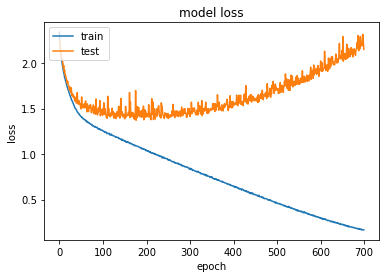

In [63]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [64]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\User\Desktop\Python\PRACTICE\Speech-Emotion-Analyzer-master\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model.h5 


In [65]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [66]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
print("Performance: ")

loaded_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy', fscore, precision, recall ])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
for i in range(len(loaded_model.metrics_names)):
    print("%s: %.2f%%" % (loaded_model.metrics_names[i], score[i]*100))

Loaded model from disk
Performance: 
loss: 214.97%
accuracy: 48.88%
fscore: 46.77%
precision: 49.54%
recall: 44.36%


## Predicting emotions on the test data

In [67]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

12/12 [==============================] - 1s 16ms/step


In [68]:
preds

array([[6.0326030e-04, 8.5271329e-01, 3.9327178e-02, ..., 5.4131460e-10,
        1.6691261e-05, 2.2861143e-03],
       [1.1150729e-03, 1.0036713e-03, 2.4518353e-05, ..., 1.9481313e-07,
        4.9920482e-06, 1.5260655e-05],
       [4.7708590e-02, 1.1855471e-01, 2.0899850e-07, ..., 7.9032009e-10,
        1.0393408e-07, 1.4823006e-04],
       ...,
       [7.4037549e-04, 2.1927159e-04, 6.3290389e-07, ..., 2.0740833e-03,
        9.1668626e-04, 5.0708377e-01],
       [5.4312393e-05, 3.6069812e-09, 9.2041148e-08, ..., 1.6732475e-02,
        1.8983319e-02, 3.0721392e-04],
       [2.5332120e-04, 8.8413471e-10, 7.4851499e-08, ..., 4.4815028e-01,
        4.2262983e-01, 1.4895067e-02]], dtype=float32)

In [69]:
preds1=preds.argmax(axis=1)

In [70]:
preds1

array([1, 3, 4, 9, 7, 0, 4, 3, 6, 0, 4, 3, 3, 8, 3, 0, 0, 6, 7, 5, 6, 5,
       4, 6, 7, 9, 4, 6, 8, 6, 9, 7, 1, 5, 3, 1, 7, 7, 1, 7, 6, 4, 2, 6,
       0, 4, 2, 4, 9, 7, 3, 4, 4, 6, 1, 9, 8, 9, 9, 4, 3, 0, 5, 6, 5, 7,
       3, 0, 5, 5, 2, 4, 7, 5, 1, 6, 8, 1, 3, 0, 8, 6, 5, 4, 8, 8, 5, 6,
       2, 7, 9, 1, 4, 9, 0, 5, 4, 2, 5, 0, 6, 3, 6, 6, 1, 6, 6, 7, 2, 3,
       1, 8, 7, 0, 5, 6, 6, 0, 9, 8, 6, 8, 6, 7, 9, 6, 7, 8, 0, 6, 0, 3,
       9, 6, 7, 0, 6, 6, 4, 5, 0, 3, 0, 0, 0, 2, 9, 0, 6, 1, 6, 5, 0, 3,
       6, 7, 4, 7, 1, 6, 9, 1, 6, 1, 3, 4, 0, 4, 6, 9, 5, 4, 6, 5, 5, 7,
       1, 2, 3, 0, 5, 7, 3, 0, 0, 3, 3, 6, 3, 8, 1, 1, 0, 0, 9, 1, 4, 3,
       5, 9, 3, 7, 1, 0, 8, 0, 5, 3, 2, 5, 7, 2, 6, 4, 9, 8, 4, 6, 6, 8,
       7, 8, 0, 4, 9, 0, 4, 2, 1, 9, 5, 6, 8, 2, 6, 9, 4, 2, 6, 7, 4, 8,
       7, 2, 1, 8, 2, 1, 0, 7, 4, 5, 6, 6, 7, 0, 9, 1, 7, 0, 6, 0, 1, 9,
       1, 4, 5, 2, 1, 0, 3, 4, 2, 0, 5, 1, 1, 5, 5, 6, 1, 1, 6, 4, 1, 0,
       0, 3, 5, 5, 6, 1, 0, 7, 9, 2, 8, 0, 9, 7, 0,

In [71]:
abc = preds1.astype(int).flatten()

In [72]:
abc

array([1, 3, 4, 9, 7, 0, 4, 3, 6, 0, 4, 3, 3, 8, 3, 0, 0, 6, 7, 5, 6, 5,
       4, 6, 7, 9, 4, 6, 8, 6, 9, 7, 1, 5, 3, 1, 7, 7, 1, 7, 6, 4, 2, 6,
       0, 4, 2, 4, 9, 7, 3, 4, 4, 6, 1, 9, 8, 9, 9, 4, 3, 0, 5, 6, 5, 7,
       3, 0, 5, 5, 2, 4, 7, 5, 1, 6, 8, 1, 3, 0, 8, 6, 5, 4, 8, 8, 5, 6,
       2, 7, 9, 1, 4, 9, 0, 5, 4, 2, 5, 0, 6, 3, 6, 6, 1, 6, 6, 7, 2, 3,
       1, 8, 7, 0, 5, 6, 6, 0, 9, 8, 6, 8, 6, 7, 9, 6, 7, 8, 0, 6, 0, 3,
       9, 6, 7, 0, 6, 6, 4, 5, 0, 3, 0, 0, 0, 2, 9, 0, 6, 1, 6, 5, 0, 3,
       6, 7, 4, 7, 1, 6, 9, 1, 6, 1, 3, 4, 0, 4, 6, 9, 5, 4, 6, 5, 5, 7,
       1, 2, 3, 0, 5, 7, 3, 0, 0, 3, 3, 6, 3, 8, 1, 1, 0, 0, 9, 1, 4, 3,
       5, 9, 3, 7, 1, 0, 8, 0, 5, 3, 2, 5, 7, 2, 6, 4, 9, 8, 4, 6, 6, 8,
       7, 8, 0, 4, 9, 0, 4, 2, 1, 9, 5, 6, 8, 2, 6, 9, 4, 2, 6, 7, 4, 8,
       7, 2, 1, 8, 2, 1, 0, 7, 4, 5, 6, 6, 7, 0, 9, 1, 7, 0, 6, 0, 1, 9,
       1, 4, 5, 2, 1, 0, 3, 4, 2, 0, 5, 1, 1, 5, 5, 6, 1, 1, 6, 4, 1, 0,
       0, 3, 5, 5, 6, 1, 0, 7, 9, 2, 8, 0, 9, 7, 0,

In [73]:
predictions = (lb.inverse_transform((abc)))

In [79]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf.head(10)

,predictedvalues
0,female_calm
1,female_happy
2,female_sad
3,male_sad
4,male_fearful
5,female_angry
6,female_sad
7,female_happy
8,male_calm
9,female_angry


In [80]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [82]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf.head(10)

,actualvalues
0,female_calm
1,female_happy
2,female_sad
3,male_fearful
4,male_fearful
5,female_angry
6,female_calm
7,female_sad
8,male_calm
9,female_angry


In [83]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [84]:
finaldf

,actualvalues,predictedvalues
0,female_calm,female_calm
1,female_happy,female_happy
2,female_sad,female_sad
3,male_fearful,male_sad
4,male_fearful,male_fearful
...,...,...
353,male_fearful,male_fearful
354,male_happy,male_sad
355,male_calm,male_sad
356,male_fearful,male_angry


In [85]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,44
female_calm,41
female_fearful,22
female_happy,25
female_sad,34
male_angry,38
male_calm,41
male_fearful,39
male_happy,38


In [86]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,46
female_calm,36
female_fearful,20
female_happy,31
female_sad,37
male_angry,37
male_calm,58
male_fearful,35
male_happy,29


In [87]:
finaldf.to_csv('Predictions.csv', index=False)

# Building Confusion Matrix:

In [97]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [98]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
print("Accuracy: ")
accuracy_score(y_true, y_pred)*100

Accuracy: 


48.882681564245814

In [99]:
from sklearn.metrics import f1_score
print("Fscore: ")
f1_score(y_true, y_pred, average='macro') *100

Fscore: 


47.7447983889859

Visualize Confusion Matrix 

In [100]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[26,  2,  3,  5,  3,  2,  1,  2,  0,  0],
       [ 1, 21,  1,  2, 13,  0,  0,  0,  0,  3],
       [ 3,  0, 10,  5,  4,  0,  0,  0,  0,  0],
       [ 2,  3,  4, 12,  3,  0,  0,  0,  1,  0],
       [ 6,  9,  1,  4, 12,  0,  0,  0,  0,  2],
       [ 1,  0,  0,  0,  0, 23,  4,  3,  7,  0],
       [ 1,  0,  0,  1,  0,  1, 29,  1,  2,  6],
       [ 3,  0,  0,  1,  2,  3,  5, 19,  4,  2],
       [ 1,  1,  0,  0,  0,  8,  2,  7, 13,  6],
       [ 2,  0,  1,  1,  0,  0, 17,  3,  2, 10]], dtype=int64)

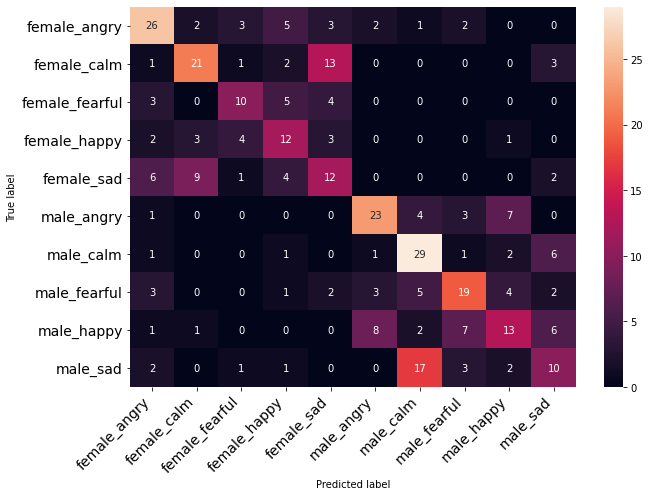

In [101]:


# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
#class_names = ['male_negative', 'male_positive']
class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)

# Recording Voice

In [104]:
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv

In [264]:
# Sampling frequency
freq = 44100

# Recording duration
duration = 6
#Start recorder with the given values of 
# duration and sample frequency
recording = sd.rec(int(duration * freq), 
                   samplerate=freq, channels=2)
print("Recording......")

# Record audio for the given number of seconds
sd.wait()
print("Recording Complete ")
write('output.wav', freq, recording) 

Recording......
Recording Complete 


## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [265]:
data, sampling_rate = librosa.load('output.wav')

Populating the interactive namespace from numpy and matplotlib


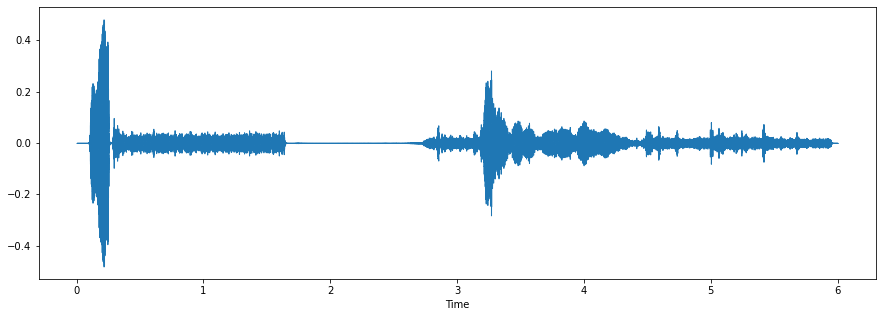

In [266]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [267]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [268]:
livedf2= pd.DataFrame(data=livedf2)

In [269]:
livedf2 = livedf2.stack().to_frame().T

In [270]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-14.371395,-13.490477,-12.681355,-13.653669,-15.833832,-17.972765,-17.358543,-18.438021,-13.776795,-10.27114,...,-14.111677,-14.218884,-16.142998,-17.714161,-18.056044,-17.843319,-18.826679,-20.361816,-21.562866,-18.933218


In [271]:
twodim= np.expand_dims(livedf2, axis=2)

In [272]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 261ms/step


In [273]:
livepreds

array([[2.4993736e-02, 3.9584180e-10, 5.3241024e-07, 1.4300838e-01,
        1.4335299e-09, 1.0986188e-08, 3.3660290e-05, 3.7214562e-10,
        4.3258838e-02, 7.8870487e-01]], dtype=float32)

In [274]:
livepreds1=livepreds.argmax(axis=1)

In [275]:
liveabc = livepreds1.astype(int).flatten()

In [276]:
livepredictions = (lb.inverse_transform((liveabc)))

In [279]:
import sounddevice as sd
import soundfile as sf

filename = 'output.wav'
# Extract data and sampling rate from file
data, fs = sf.read(filename, dtype='float32')  
sd.play(data, fs)
status = sd.wait()

In [280]:
pre=livepredictions[0].split("_")
print("The Voice Sounds ",pre[1])


The Voice Sounds  sad
